# *Sentiment Analysis for Financial News*

In [ ]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install tqdm

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import os

In [ ]:
from huggingface_hub import login

login(token="hfk")

In [ ]:
model_name = "yiyanghkust/finbert-tone"  # FinBERT pretrained for finance
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0)


Device set to use cpu


In [ ]:
# Function for sentiment analysis
def analyze_sentiment(texts):
    results = []
    for t in tqdm(texts, desc="Processing Sentiment"):
        if pd.isna(t) or t.strip() == "":
            results.append({"label": "NEUTRAL", "score": 0.0})
            continue
        res = sentiment_pipeline(t[:512])[0]  # Truncate text to 512 tokens
        results.append(res)
    return results

In [ ]:
#  Load your CSV files
files = {
    "Tesla": "Tesla_news.csv",
    "Apple": "Apple_news.csv",
    "Amazon": "Amazon_news.csv"
}

In [ ]:
# Dictionary to store sentiment results
sentiment_dfs = {}

for company, file in files.items():
    df = pd.read_csv(file)
    print(f"\nProcessing {company} data: {len(df)} rows")

    # Combine title + description for sentiment input
    df['text'] = df.apply(
        lambda x: str(x['title']) + ". " + str(x['description']) if pd.notna(x['description']) else str(x['title']),
        axis=1
    )

    # Convert publishedAt to datetime
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])

    # Run sentiment analysis
    sentiments = analyze_sentiment(df['text'].tolist())

    # Add results to dataframe
    df['sentiment_label'] = [s['label'] for s in sentiments]
    df['sentiment_score'] = [s['score'] for s in sentiments]

    # Save the dataframe with sentiment
    output_file = f"{company.lower()}_sentiment.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved sentiment data to {output_file}")

    sentiment_dfs[company] = df


Processing Tesla data: 96 rows


Processing Sentiment: 100%|██████████| 96/96 [00:28<00:00,  3.33it/s]


Saved sentiment data to tesla_sentiment.csv

Processing Apple data: 97 rows


Processing Sentiment: 100%|██████████| 97/97 [00:27<00:00,  3.51it/s]


Saved sentiment data to apple_sentiment.csv

Processing Amazon data: 98 rows


Processing Sentiment: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]

Saved sentiment data to amazon_sentiment.csv


# *Stock Forecasting*

In [ ]:
!pip install tensorflow.keras
!pip install tensorflow.keras
!pip install prophet tensorflow scikit-learn pandas numpy matplotlib tqdm

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [ ]:
companies = {
    "tesla": "tesla_features.csv",
    "apple": "apple_features.csv",
    "amazon": "amazon_features.csv"
}

results = []

In [ ]:
def evaluate_models(company, df):
    print(f"\n Processing {company.upper()}")

    target = "Close"
    features = [
        'Open', 'High', 'Low', 'Volume', 'Daily_Return',
        'MA_3', 'MA_7', 'Volatility_7',
        'sentiment_score_mean', 'Sentiment_MA_3', 'Sentiment_MA_7'
    ]

    df = df.dropna()
    X = df[features]
    y = df[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # ----------------------------
    # 1️⃣ LSTM Model
    # ----------------------------
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)

    y_pred_lstm = model.predict(X_test_lstm)
    rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
    r2_lstm = r2_score(y_test, y_pred_lstm)

    # ----------------------------
    # 2️⃣ Prophet Model
    # ----------------------------
    df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

    train_size = int(len(df_prophet) * 0.8)
    train_df = df_prophet.iloc[:train_size]
    test_df = df_prophet.iloc[train_size:]

    model_prophet = Prophet()
    model_prophet.fit(train_df)
    future = model_prophet.make_future_dataframe(periods=len(test_df))
    forecast = model_prophet.predict(future)
    pred = forecast.iloc[-len(test_df):]['yhat'].values

    rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], pred))
    r2_prophet = r2_score(test_df['y'], pred)

    # ----------------------------
    # 3️⃣ Random Forest
    # ----------------------------
    rf = RandomForestRegressor(n_estimators=150, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)

    # ----------------------------
    # 📊 Store Results
    # ----------------------------
    results.append({
        'Company': company.upper(),
        'LSTM_RMSE': rmse_lstm, 'LSTM_R2': r2_lstm,
        'Prophet_RMSE': rmse_prophet, 'Prophet_R2': r2_prophet,
        'RF_RMSE': rmse_rf, 'RF_R2': r2_rf
    })


In [ ]:
# Run for All Companies
for company, file in companies.items():
    df = pd.read_csv(file)
    evaluate_models(company, df)


 Processing TESLA


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/3x8dhx5_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/8zh7rm0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83729', 'data', 'file=/tmp/tmpndn6kby_/3x8dhx5_.json', 'init=/tmp/tmpndn6kby_/8zh7rm0g.json', 'output', 'file=/tmp/tmpndn6kby_/prophet_modelq248dbpf/prophet_model-20251015010344.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



 Processing APPLE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/3k0zgvvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/3er0ymsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22576', 'data', 'file=/tmp/tmpndn6kby_/3k0zgvvo.json', 'init=/tmp/tmpndn6kby_/3er0ymsy.json', 'output', 'file=/tmp/tmpndn6kby_/prophet_modelx4ax5w5b/prophet_model-20251015010349.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



 Processing AMAZON


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/3ac0jc63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpndn6kby_/b3zd6l0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96237', 'data', 'file=/tmp/tmpndn6kby_/3ac0jc63.json', 'init=/tmp/tmpndn6kby_/b3zd6l0v.json', 'output', 'file=/tmp/tmpndn6kby_/prophet_modelmqeuxa8v/prophet_model-20251015010354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Display Results
results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
display(results_df)


Final Model Comparison:


,Company,LSTM_RMSE,LSTM_R2,Prophet_RMSE,Prophet_R2,RF_RMSE,RF_R2
0,TESLA,413.070553,-502.390215,289.727267,-246.648121,73.572952,-14.969549
1,TESLA,401.730586,-475.130602,289.727267,-246.648121,73.572952,-14.969549
2,APPLE,228.771412,-708.404114,176.331603,-420.454318,13.449444,-1.451878
3,AMAZON,199.392233,-1393.853119,151.447695,-803.706183,2.108807,0.843978


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Compute Accuracy (%)
for company in results_df['Company']:
    df = pd.read_csv(companies[company.lower()])
    actual_mean = df['Close'].mean()
    for model in ['LSTM', 'Prophet', 'RF']:
        rmse_col = f'{model}_RMSE'
        acc_col = f'{model}_Accuracy'
        results_df.loc[results_df['Company'] == company, acc_col] = (
            (1 - (results_df.loc[results_df['Company'] == company, rmse_col] / actual_mean)) * 100
        )

In [ ]:
#Display Full Table
print("📋 Final Results with RMSE, R², and Accuracy:")
display(results_df.round(3))


📋 Final Results with RMSE, R², and Accuracy:


,Company,LSTM_RMSE,LSTM_R2,Prophet_RMSE,Prophet_R2,RF_RMSE,RF_R2,LSTM_Accuracy,Prophet_Accuracy,RF_Accuracy
0,TESLA,413.071,-502.390,289.727,-246.648,73.573,-14.970,-19.932,15.880,78.639
1,TESLA,401.731,-475.131,289.727,-246.648,73.573,-14.970,-16.640,15.880,78.639
2,APPLE,228.771,-708.404,176.332,-420.454,13.449,-1.452,-4.251,19.646,93.871
3,AMAZON,199.392,-1393.853,151.448,-803.706,2.109,0.844,8.422,30.442,99.031


In [ ]:
# Best Model per Company
best_models = []

for _, row in results_df.iterrows():
    company = row['Company']
    model_scores = {
        'LSTM': row['LSTM_Accuracy'],
        'Prophet': row['Prophet_Accuracy'],
        'RF': row['RF_Accuracy']
    }
    best_model = max(model_scores, key=model_scores.get)
    best_accuracy = model_scores[best_model]
    best_models.append({
        'Company': company,
        'Best_Model': best_model,
        'Best_Accuracy(%)': round(best_accuracy, 2)
    })

best_df = pd.DataFrame(best_models)
print("\n🏆 Best Model for Each Company:")
display(best_df)


🏆 Best Model for Each Company:


,Company,Best_Model,Best_Accuracy(%)
0,TESLA,RF,78.64
1,TESLA,RF,78.64
2,APPLE,RF,93.87
3,AMAZON,RF,99.03


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


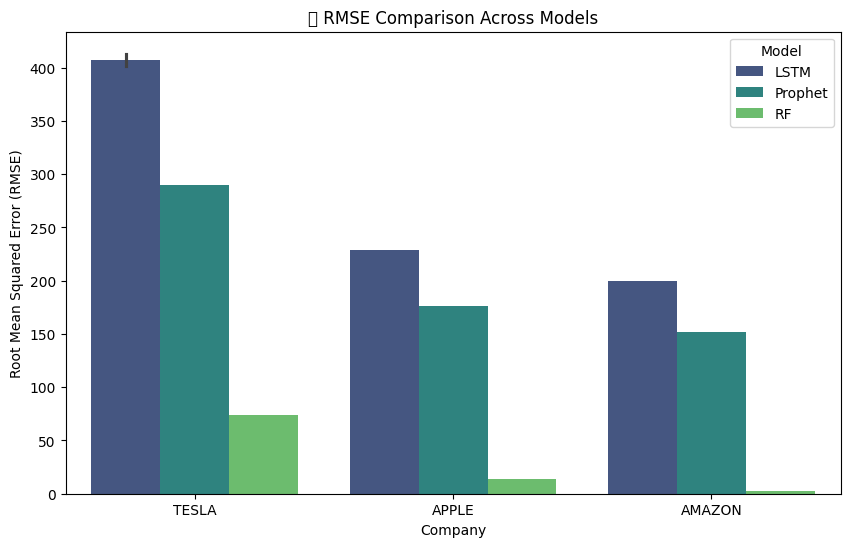

In [ ]:
# Visualization - RMSE

melt_rmse = results_df.melt(
    id_vars='Company',
    value_vars=['LSTM_RMSE', 'Prophet_RMSE', 'RF_RMSE'],
    var_name='Model', value_name='RMSE'
)
melt_rmse['Model'] = melt_rmse['Model'].str.replace('_RMSE', '')

plt.figure(figsize=(10, 6))
sns.barplot(data=melt_rmse, x='Company', y='RMSE', hue='Model', palette='viridis')
plt.title('📉 RMSE Comparison Across Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Company')
plt.legend(title='Model')
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


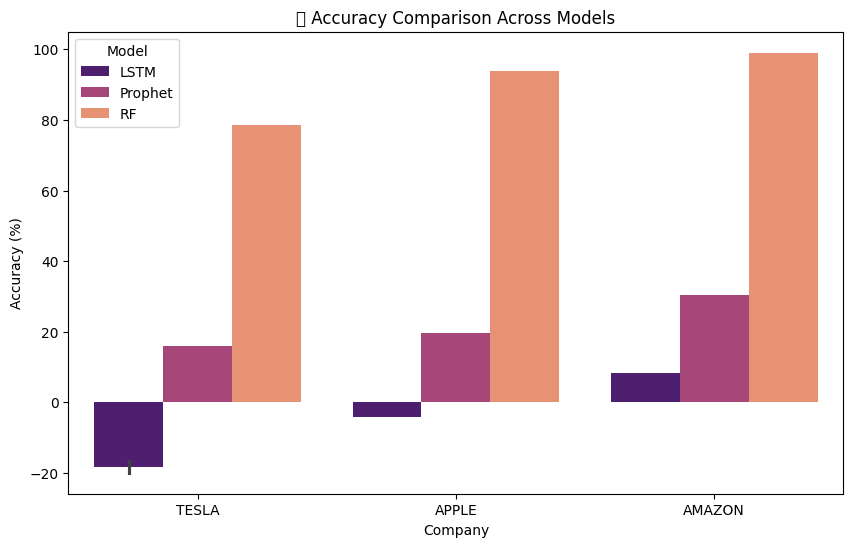

In [ ]:
#  Visualization - Accuracy
melt_acc = results_df.melt(
    id_vars='Company',
    value_vars=['LSTM_Accuracy', 'Prophet_Accuracy', 'RF_Accuracy'],
    var_name='Model', value_name='Accuracy(%)'
)
melt_acc['Model'] = melt_acc['Model'].str.replace('_Accuracy', '')

plt.figure(figsize=(10, 6))
sns.barplot(data=melt_acc, x='Company', y='Accuracy(%)', hue='Model', palette='magma')
plt.title('📈 Accuracy Comparison Across Models')
plt.ylabel('Accuracy (%)')
plt.xlabel('Company')
plt.legend(title='Model')
plt.show()

In [ ]:
# Save the Best Model per Company
import joblib
import os

save_dir = "best_models"
os.makedirs(save_dir, exist_ok=True)

for i, row in best_df.iterrows():
    company = row['Company'].lower()
    best_model = row['Best_Model']
    print(f"\nSaving best model for {company.upper()}: {best_model}")

    # Reload the dataset to re-train only that best model fully on all data
    df = pd.read_csv(companies[company])
    df = df.dropna()

    features = [
        'Open', 'High', 'Low', 'Volume', 'Daily_Return',
        'MA_3', 'MA_7', 'Volatility_7',
        'sentiment_score_mean', 'Sentiment_MA_3', 'Sentiment_MA_7'
    ]
    target = "Close"
    X = df[features]
    y = df[target]

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Save the scaler for consistency in VS
    joblib.dump(scaler, f"{save_dir}/{company}_scaler.pkl")

    if best_model == "RF":
        model = RandomForestRegressor(n_estimators=200, random_state=42)
        model.fit(X_scaled, y)
        joblib.dump(model, f"{save_dir}/{company}_rf.pkl")

    elif best_model == "Prophet":
        df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
        df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
        model = Prophet()
        model.fit(df_prophet)
        joblib.dump(model, f"{save_dir}/{company}_prophet.pkl")

    elif best_model == "LSTM":
        X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
        model = Sequential([
            LSTM(64, return_sequences=False, input_shape=(1, X_scaled.shape[1])),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_lstm, y, epochs=20, batch_size=16, verbose=0)
        model.save(f"{save_dir}/{company}_lstm.h5")

    print(f"Saved {company.upper()} model to {save_dir}/")

print("\nAll best models and scalers saved successfully!")



Saving best model for TESLA: RF
Saved TESLA model to best_models/

Saving best model for TESLA: RF
Saved TESLA model to best_models/

Saving best model for APPLE: RF
Saved APPLE model to best_models/

Saving best model for AMAZON: RF
Saved AMAZON model to best_models/

All best models and scalers saved successfully!


In [ ]:
#download the model
from google.colab import files
for f in os.listdir(save_dir):
    files.download(os.path.join(save_dir, f))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>